# Solving problems

Let's try to define a problem so that Qiskit can be used to explore the potential solutions and hopefully we have and advantage with respect to classical means. One interesting thing about quantum computers is that supperposition can be used to evaluate all potential outcomes of an action.

Lets see what happens if we apply hadamard gates to every qubit in our circuit.

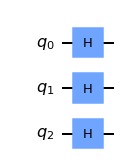

In [3]:
from qiskit import QuantumCircuit

circ = QuantumCircuit(3)

# Hadamard gate
for i in range(3):
    circ.h(i)
circ.draw('mpl')

Circuits are initialized to their $|0\rangle^{\otimes n}$ state, so if we measure several times the outcome we can get an understanding on the outcome probabilities...

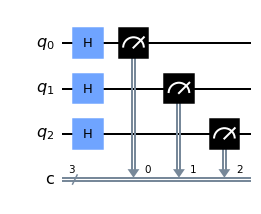

In [4]:
qc = QuantumCircuit(3,3)
qc.compose(circ, inplace=True)
qc.measure([0, 1,2],[0, 1, 2])
qc.draw('mpl')

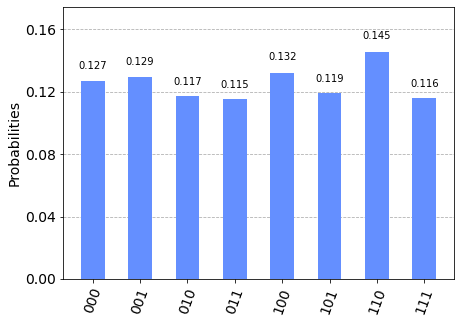

In [5]:
from qiskit import Aer, execute
from qiskit.visualization import plot_histogram

# execute the quantum circuit
backend = Aer.get_backend('qasm_simulator') # the device to run on
result = execute(qc, backend, shots=1000).result()
counts  = result.get_counts(qc)

plot_histogram(counts)

Pay attention that this is not a sequential thing. Measuring process hides the fact that all those states at happening all at once.

In [6]:
import qiskit.quantum_info as qi
psi = qi.Statevector.from_instruction(circ)
psi.draw('latex', prefix='|\\psi\\rangle = ')

<IPython.core.display.Latex object>

So, that allows to evaluate all posible outcomes of an action at the same time. Imagine we introduce a flip o the middle qubit ($X$ gate).

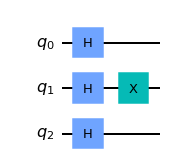

In [7]:
circ.x(1)
circ.draw('mpl')

In [8]:
psi = qi.Statevector.from_instruction(circ)
psi.draw('latex', prefix='|\\psi\\rangle = ')

<IPython.core.display.Latex object>

Seems like nothing has happened but in fact this is given the state the system is at. Looking at the bloch sphere it may be clearer...

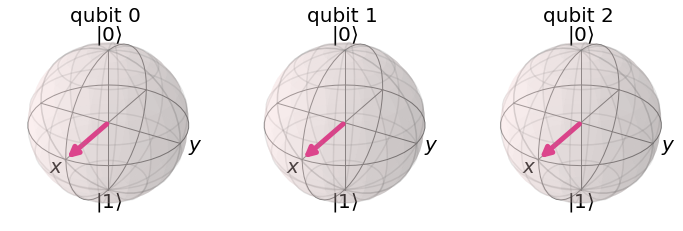

In [9]:
from qiskit.visualization import plot_bloch_multivector

plot_bloch_multivector(psi)

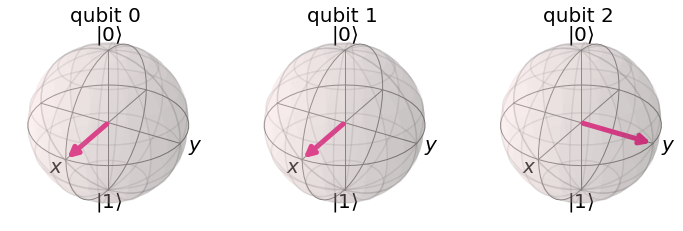

In [10]:
from math import pi

circ.rz(pi/2, 2)
psi = qi.Statevector.from_instruction(circ)
plot_bloch_multivector(psi)

In [11]:
psi.draw('latex', prefix='|\\psi\\rangle = ')

<IPython.core.display.Latex object>

Now we can see this movement affects on the $Z$ axis of our qubits although it cannot be perceibed when measuing on a classical register.

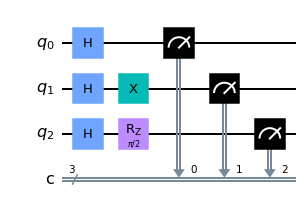

In [12]:
qc = QuantumCircuit(3,3)
qc.compose(circ, inplace=True)
qc.measure([0, 1,2],[0, 1, 2])
qc.draw('mpl')

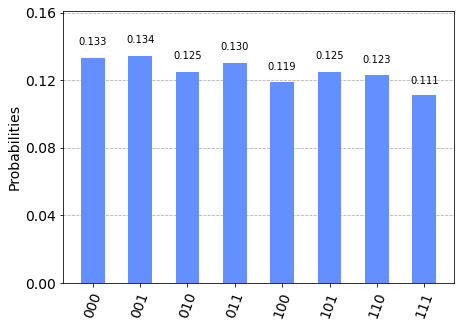

In [13]:
result = execute(qc, backend, shots=1000).result()
counts  = result.get_counts(qc)

plot_histogram(counts)

We can affect this modified $Z$ axis mapping to a $X$ rotation that will affect and indeed modify the final result.

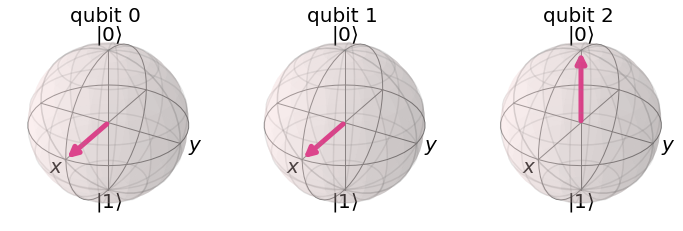

In [14]:
circ.rx(pi/2, 0)
circ.rx(pi/2, 1)
circ.rx(pi/2, 2)
psi = qi.Statevector.from_instruction(circ)
plot_bloch_multivector(psi)

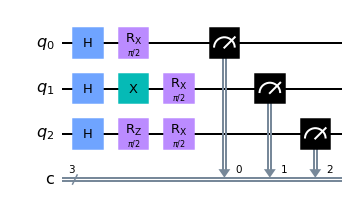

In [15]:
qc = QuantumCircuit(3,3)
qc.compose(circ, inplace=True)
qc.measure([0, 1,2],[0, 1, 2])
qc.draw('mpl')

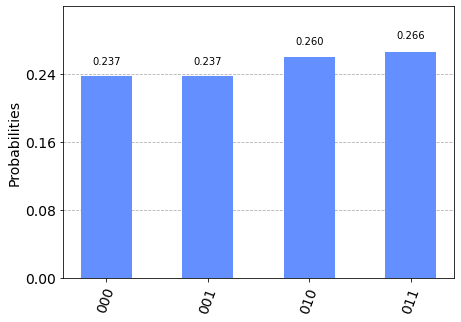

In [16]:
result = execute(qc, backend, shots=1000).result()
counts  = result.get_counts(qc)

plot_histogram(counts)

This fact can be used to affect the quantum state so that helps us compute all pottential solutions for a given problem.

# MaxCut

The MaxCut problem is a classical one, we need to split a set of nodes into two set so that such that the maximum number of edges between the sets is maximum. Take this graph as an example.

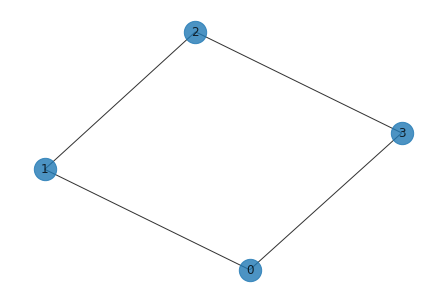

In [17]:
import networkx as nx

G = nx.Graph()
G.add_nodes_from([0, 1, 2, 3])
G.add_edges_from([(0, 1), (1, 2), (2, 3), (3, 0)])
nx.draw(G, with_labels=True, alpha=0.8, node_size=500)

For 4 nodes, as each node can be assigned to either the one or the other set, there are $2^4 = 16$ possible assigments, out of which we have to find one that gives maximum number of edges between the two sets. In this particular setting we can easilly see that the two possible options if we anumerate the nodes are 0101 or 1010. But we need to find a procedural way that achieves that.

According to what we saw before we can set a 4 qubit register so that each node gets linked to the corresponding one.

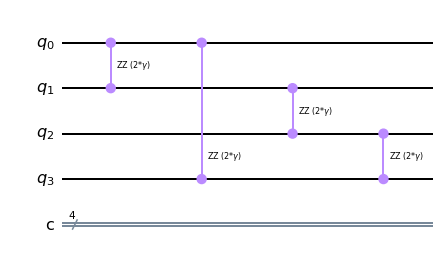

In [18]:
from qiskit.circuit import Parameter

# Create a parameter to instantiate
gamma = Parameter("$\\gamma$")

qc = QuantumCircuit(4,4)
qc.rzz(2*gamma, 0,1)
qc.rzz(2*gamma, 0,3)
qc.rzz(2*gamma, 1,2)
qc.rzz(2*gamma, 2,3)
qc.draw('mpl')

If we set the initial quantum state on a supperposition off all potential solutions...

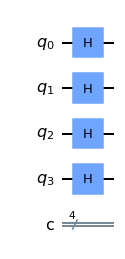

In [19]:
init = QuantumCircuit(4,4)
for i in range(4):
    init.h(i)

init.draw('mpl')

Mixer circuit takes the effect on those qubits where the $Z$ axis rotation allignes with the effect of $X$ for highlighting the solutions to our problem.

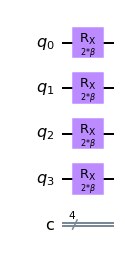

In [20]:
# Create a parameter to instantiate
beta = Parameter("$\\beta$")

mixer = QuantumCircuit(4,4)
for i in range(4):
    mixer.rx(2*beta, i)
    
mixer.draw('mpl')

And combine the three... and add some measurements.

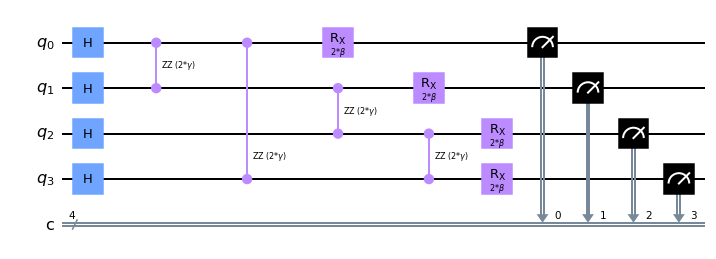

In [21]:
maxcut = QuantumCircuit(4,4)
maxcut.compose(init, inplace=True)
maxcut.compose(qc, inplace=True)
maxcut.compose(mixer, inplace=True)
maxcut.measure(range(4), range(4))
maxcut.draw('mpl')

Trust me on these parameters, we will show how they are obtained later.

In [22]:
qc = maxcut.bind_parameters([1.9793337, 1.16663483])

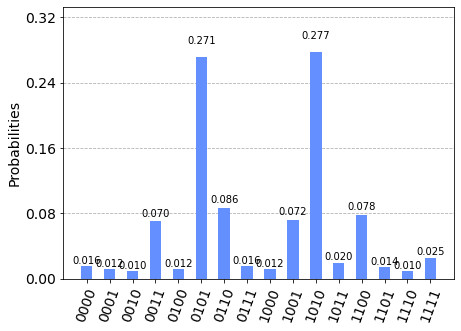

In [23]:
result = execute(qc, backend, shots=512).result()
counts  = result.get_counts(qc)

plot_histogram(counts)

We can see the probability of obtaining our solutions if a single run is made.

In [24]:
num_0101 = counts['0101']
print(f'Probability of getting the result 0101 is {num_0101/512}')

Probability of getting the result 0101 is 0.271484375


## QAOA

QAOA (Quantum Approximate Optimization Algorithm) introduced by [Farhi et al.](https://arxiv.org/abs/1411.4028) is a quantum algorithm that attempts to solve such combinatorial problems.

It is a variational algorithm that uses a unitary $U(\beta,\gamma)$ characterized by the parameters $(\beta,\gamma)$ to prepare a quantum state $|\psi(\beta,\gamma)\rangle$. The goal of the algorithm is to find optimal parameters $(\beta_{opt},\gamma_{opt})$ such that the quantum state $|\psi(\beta_{opt},\gamma_{opt})\rangle$ encodes the solution to the problem.

Lets put all the componens to build the circuit in a single function.

In [25]:
def create_qaoa_circ(G, theta):
    
    """
    Creates a parametrized qaoa circuit
    
    Args:  
        G: networkx graph
        theta: list
               unitary parameters
                     
    Returns:
        qc: qiskit circuit
    """
    
    # Number of nodes   
    nqubits = len(G.nodes())
    qc = QuantumCircuit(nqubits)
    
    beta = theta[:1]
    gamma = theta[1:]
    
    # initial_state
    for i in range(0, nqubits):
        qc.h(i)
           
    # problem unitary
    for pair in list(G.edges()):
        qc.rzz(2 * gamma[0], pair[0], pair[1])

    # mixer unitary
    for i in range(0, nqubits):
        qc.rx(2 * beta[0], i)
            
    qc.measure_all()
        
    return qc

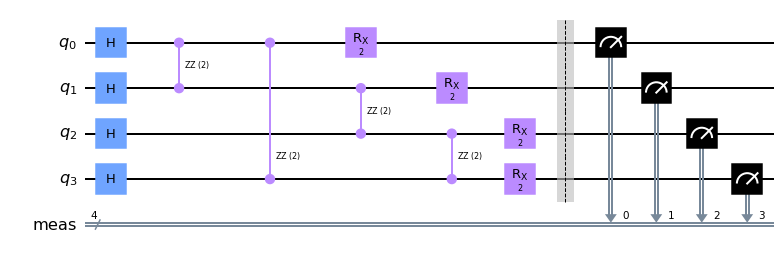

In [26]:
qc = create_qaoa_circ(G, [1.0, 1.0])
qc.draw('mpl')

Also, in order to optimize and find the solution to our problem, and objective function needs to be defined.

In [27]:
def maxcut_obj(x, G):
    """
    Given a bitstring as a solution, this function returns
    the number of edges shared between the two partitions
    of the graph.
    
    Args:
        x: str
           solution bitstring
           
        G: networkx graph
        
    Returns:
        obj: float
             Objective
    """
    obj = 0
    for i, j in G.edges():
        if x[i] != x[j]:
            obj -= 1
            
    return obj

In [28]:
maxcut_obj('1010', G)

-4

In [29]:
maxcut_obj('1000', G)

-2

For this simple problems it is easy to compute the whole energy landscape. It will not be like that for bigger problems. for each set of parameters we will need to compute and expectation value of the energy so that when the optimal value is chosen with a higher probability the expectation will rise to its maximum.

In [30]:
def compute_expectation(counts, G):
    
    """
    Computes expectation value based on measurement results
    
    Args:
        counts: dict
                key as bitstring, val as count
           
        G: networkx graph
        
    Returns:
        avg: float
             expectation value
    """
    
    avg = 0
    sum_count = 0
    for bitstring, count in counts.items():
        
        obj = maxcut_obj(bitstring, G)
        avg += obj * count
        sum_count += count
        
    return avg/sum_count

In [31]:
counts = {'1010': 500, '1000': 500}
compute_expectation(counts, G)

-3.0

In [32]:
counts = {'1010': 1000}
compute_expectation(counts, G)

-4.0

In [33]:
counts = {'1010': 500, '0101': 500}
compute_expectation(counts, G)

-4.0

Finally we will set the procedure that gets the expectation value to each run so that we could call to the optimization rutine to find $(\beta_{opt},\gamma_{opt})$

In [34]:
# Finally we write a function that executes the circuit on the chosen backend
def get_expectation(G, shots=512):
    
    """
    Runs parametrized circuit
    
    Args:
        G: networkx graph
        p: int,
           Number of repetitions of unitaries
    """
    
    backend = Aer.get_backend('qasm_simulator')
    backend.shots = shots
    
    def execute_circ(theta):
        
        qc = create_qaoa_circ(G, theta)
        counts = backend.run(qc, seed_simulator=10, 
                             nshots=512).result().get_counts()
        
        return compute_expectation(counts, G)
    
    return execute_circ

In [35]:
from scipy.optimize import minimize

# Expectation function
expectation = get_expectation(G)

# Minimize starting from (1,1) and using COBYLA optimizer
res = minimize(expectation, [1.0, 1.0], method='COBYLA')
res

     fun: -2.994140625
   maxcv: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 30
  status: 1
 success: True
       x: array([1.9793337 , 1.16663483])

We could use the QASM definition in roder to sotre our circuit and import it on a different framework.

In [36]:
qc = create_qaoa_circ(G, res.x)
oqasm = qc.qasm()
with open("mycircuit.qasm",'w') as file:
    file.write(oqasm)

## References

* Qiskit reference on solving MaxCut using QAOA: [here](https://qiskit.org/textbook/ch-applications/qaoa.html)